## 深層学習の実習

### 訓練データとテストデータそれぞれの画像ファイルを読み込む

#### `image_dataset_from_directory()` で読み込む

In [1]:
# 訓練データとテストデータの画像を読み込む
# （サイズは縦横224pxにリサイズする）
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "nagaoka_gis/train",
    image_size=(224, 224),
    label_mode="binary",
    batch_size=32,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "nagaoka_gis/test",
    image_size=(224, 224),
    label_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 20 files belonging to 2 classes.
Found 6 files belonging to 2 classes.


#### データを確認する

In [2]:
# データの詳細を表示する
list(train_dataset.as_numpy_iterator())[0]

(array([[[[ 55.196426 ,  76.33929  ,  55.625    ],
          [ 77.92347  ,  94.92347  ,  75.92347  ],
          [ 63.81122  ,  80.81122  ,  61.97194  ],
          ...,
          [ 41.130028 ,  60.130028 ,  41.130028 ],
          [ 53.69351  ,  77.55575  ,  53.821144 ],
          [ 47.622417 ,  67.86984  ,  47.13008  ]],
 
         [[ 49.390305 ,  70.533165 ,  49.81888  ],
          [ 28.80102  ,  45.801018 ,  26.80102  ],
          [ 53.16837  ,  71.16837  ,  45.16837  ],
          ...,
          [ 53.495037 ,  72.49504  ,  51.459324 ],
          [ 60.275597 ,  83.05371  ,  56.30111  ],
          [ 26.040686 ,  42.290676 ,  33.834106 ]],
 
         [[ 68.05868  ,  89.20153  ,  68.48724  ],
          [ 58.109695 ,  75.109695 ,  56.109695 ],
          [ 48.426018 ,  65.42602  ,  46.622448 ],
          ...,
          [ 55.577    ,  75.577    ,  50.577    ],
          [ 44.354294 ,  62.44101  ,  46.262577 ],
          [ 34.68613  ,  49.431007 ,  34.385128 ]],
 
         ...,
 
         [[ 

In [3]:
# 分類名（no／yes）をリストとして格納する
class_names = train_dataset.class_names
class_names

['no', 'yes']

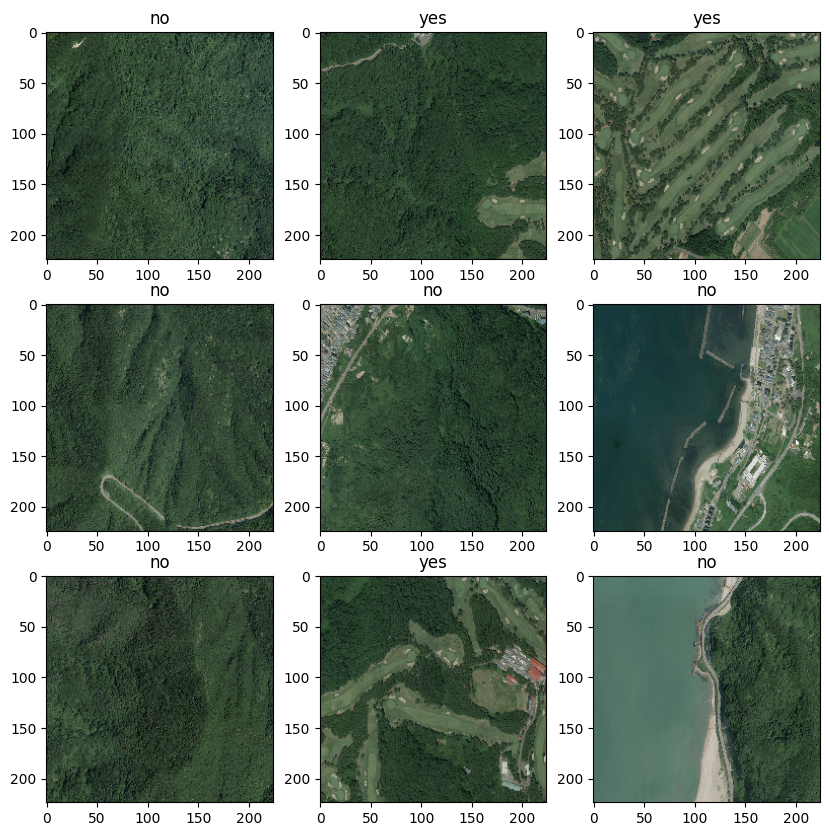

In [4]:
# 訓練データの一部を表示して確認
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

### データの水増しを行なう

In [5]:
# 画像の水増しをする関数の定義
def flip_left_right(image, label):   # 左右反転
    image = tf.image.flip_left_right(image)
    return image, label

def flip_up_down(image, label):      # 上下反転
    image = tf.image.flip_up_down(image)
    return image, label

def rot90(image, label):             # 反時計回りに90度回転
    image = tf.image.rot90(image)
    return image, label

def rot180(image, label):            # 反時計回りに180度回転
    image = tf.image.rot90(image, k=2)
    return image, label

def rot270(image, label):            # 反時計回りに270度回転
    image = tf.image.rot90(image, k=3)
    return image, label

In [6]:
# 画像の水増し処理の実行
train_dataset_lr     = train_dataset.map(flip_left_right)
train_dataset_ud     = train_dataset.map(flip_up_down)
train_dataset_rot90  = train_dataset.map(rot90)
train_dataset_rot180 = train_dataset.map(rot180)
train_dataset_rot270 = train_dataset.map(rot270)

In [7]:
# 水増ししたデータを訓練データに追加する
train_dataset = train_dataset.concatenate(train_dataset_lr)
train_dataset = train_dataset.concatenate(train_dataset_ud)
train_dataset = train_dataset.concatenate(train_dataset_rot90)
train_dataset = train_dataset.concatenate(train_dataset_rot180)
train_dataset = train_dataset.concatenate(train_dataset_rot270)

In [8]:
# データをシャッフルする
train_dataset = train_dataset.shuffle(32)

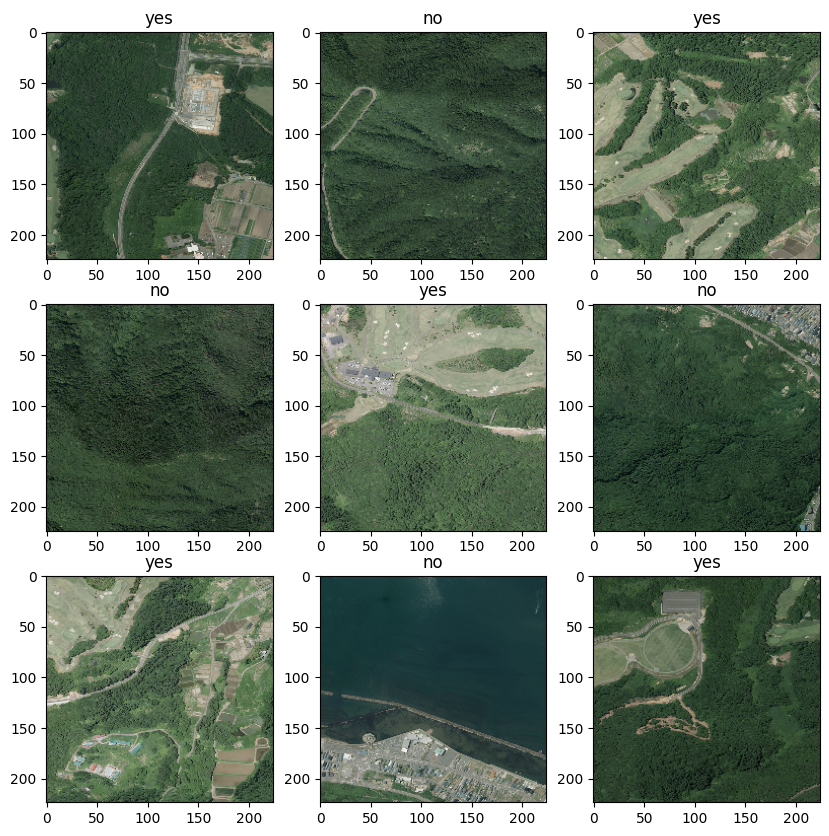

In [9]:
# 訓練データの一部を表示して確認
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

### モデルを作って学習する

#### MobileNetV2の学習済みモデルを読み込む

In [10]:
# MobileNetV2モデルを作成する
input_layer = tf.keras.Input(shape=(224, 224, 3))   # 入力層
l_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)   # 前処理（正規化）をする層

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    input_tensor=l_layer,
    include_top=False,
    weights="imagenet",
    pooling='avg'
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


#### 出力層を作成する

In [11]:
# Dense層を追加する
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

#### モデルを完成させる

In [12]:
# base_modelに先ほどのDense層を追加したモデルを作成する
model = tf.keras.Sequential([
    base_model,
    output_layer
])

In [13]:
# modelをcompileする
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [14]:
# modelに学習させる
model.fit(train_dataset, epochs=20)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.5333 - loss: 0.7769
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.7500 - loss: 0.5305
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8833 - loss: 0.3592
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9500 - loss: 0.2598
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9750 - loss: 0.2019
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9917 - loss: 0.1604
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9917 - loss: 0.1324
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9917 - loss: 0.1122
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9917 - loss: 0.0974
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9917 - loss: 0.0835
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9917 - loss: 0.0747
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9917 - lo

In [15]:
# テストデータで分類を実行する
pred_data = model.predict(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


In [16]:
# 分類した結果を確認する
pred_data

array([[0.02887815],
       [0.33332574],
       [0.07492428],
       [0.9888276 ],
       [0.7245673 ],
       [0.9054414 ]], dtype=float32)

In [17]:
# evaluate()でモデルの性能を評価する
model.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1576


[0.15756423771381378, 1.0]